In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Beta

In [2]:
def black_scholes_call(S, K, T, r, sigma):
    S = S[..., None, :]
    K = K[None, ..., None]
    T = T[None, None, None, :]
    sigma = sigma[None, :, None, None]

    call_prices = np.maximum(0, S - K) * (T <= 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_prices = np.where(T > 0, S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2), call_prices)

    return call_prices

def black_scholes_delta(S, K, T, r, sigma):
    S = S[..., None, :]
    K = K[None, ..., None]
    T = T[None, None, None, :]
    sigma = sigma[None, :, None, None]

    delta = np.where(T <= 0, np.where(S > K, 1.0, 0.0), 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = np.where(T > 0, norm.cdf(d1), delta)

    return delta

def update_cash_account_np(init_cash_account, shares_to_trade, stock_prices, r, T):
    b = np.concatenate((init_cash_account[...,None], - shares_to_trade * stock_prices[...,None,1:]),axis=-1)
    r_powers = np.exp(r*T)[None, None, None,:]
    a_series = np.cumsum(b * r_powers,axis=-1)[...,::-1] / r_powers[...,::-1]
    a_series = a_series[...,::-1]
    return a_series

In [3]:
class HedgingEnv:
    def __init__(self, S0, K, sigma, r, num_simulation, num_step, seed=None, reward_type='portfolio_diff'):
        self.S0 = S0
        self.K = K
        self.sigma = sigma
        self.r = r
        self.num_simulation = num_simulation
        self.num_step = num_step
        self.seed = seed
        self.reward_type = reward_type
        self.current_step = 0
        self.num_asset = len(S0)
        self.num_strike = K.shape[1]
        self.T = np.linspace(1, 0, num_step + 1)
        self.dt = 1 / num_step

        self.initial_portfolio_value = None
        self.option_price_initial = None
        self.initial_shares_held = None

        self.reset()

    def reset(self):
        if self.seed is not None:
            np.random.seed(self.seed)

        S0_expanded = np.tile(self.S0, (self.num_simulation, 1))[..., None]
        z = np.random.normal(0, 1, (self.num_simulation, self.num_asset, self.num_step))
        log_returns = (self.r - 0.5 * self.sigma[None, :, None]**2) * self.dt + self.sigma[None, :, None] * np.sqrt(self.dt) * z
        log_S = np.log(S0_expanded) + np.cumsum(log_returns, axis=-1)
        self.stock_prices = np.exp(log_S)
        self.stock_prices = np.concatenate((S0_expanded, self.stock_prices), axis=-1)

        self.option_prices = black_scholes_call(self.stock_prices, self.K, self.T, self.r, self.sigma)
        self.deltas = black_scholes_delta(self.stock_prices, self.K, self.T, self.r, self.sigma)
        self.shares_held = np.zeros((self.num_simulation, self.num_asset, self.num_strike)) # Initial shares held is 0 for both agents
        self.shares_to_trade = np.zeros_like(self.shares_held)

        init_cash_account = self.option_prices[..., 0] # Initial cash account is option price for seller
        self.cash_account = np.zeros((self.num_simulation, self.num_asset, self.num_strike, self.num_step + 1))
        self.cash_account[..., 0] = init_cash_account

        self.current_step = 0
        return self._get_state()

    def step(self, action):
        action = action.reshape(self.num_simulation, self.num_asset, self.num_strike)
        shares_to_trade = action

        self.shares_held = self.shares_held + shares_to_trade

        current_stock_price = self.stock_prices[..., self.current_step + 1]
        current_stock_price_expanded = np.expand_dims(current_stock_price, axis=-1)
        current_stock_price_expanded = np.repeat(current_stock_price_expanded, self.num_strike, axis=-1)

        cash_flow = - shares_to_trade * current_stock_price_expanded
        self.cash_account[..., self.current_step + 1] = self.cash_account[..., self.current_step] * np.exp(self.r * self.dt) + cash_flow

        portfolio_value = self.cash_account[..., self.current_step + 1] + self.shares_held * current_stock_price_expanded
        option_price_current = self.option_prices[..., self.current_step + 1]

        if self.reward_type == 'portfolio_diff':
            reward = -np.abs(portfolio_value - option_price_current)
        elif self.reward_type == 'negative_portfolio_value':
            reward = -portfolio_value[:, :, :]
        else:
            raise ValueError(f"Unknown reward type: {self.reward_type}")

        self.current_step += 1
        done = self.current_step >= self.num_step

        next_state = self._get_state()
        reward_reshaped = reward.reshape(-1,)
        next_state_reshaped = next_state.reshape(-1, next_state.shape[-1])

        return next_state_reshaped, reward_reshaped, done, {}

    def _get_state(self):
        # For testing, state is not used for random/perfect agent, return dummy state
        return np.zeros((self.num_simulation * self.num_asset * self.num_strike, 6))

In [4]:
# Parameters for testing
S0 = np.array([50.0, 100.0, 200.0])
K = np.array([[45.0, 55.0], [90.0, 110.0], [180.0, 220.0]])
sigma = np.array([0.15, 0.2, 0.25])
r = 0.05
num_simulation_test = 5 # Reduced simulations for plotting
num_step = 260

num_asset = len(S0)
num_strike = K.shape[1]

In [5]:
# Initialize environment for testing
test_env = HedgingEnv(S0, K, sigma, r, num_simulation_test, num_step, seed=1)

/tmp/ipykernel_1277466/1550918070.py:8: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1277466/1550918070.py:21: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [6]:
# Initialize portfolio value arrays for both agents
portfolio_value_perfect = np.zeros_like(test_env.option_prices)
portfolio_value_random = np.zeros_like(test_env.option_prices)

# Option prices for plotting
option_prices_np = test_env.option_prices

# --- Perfect Agent (Delta Hedging) Simulation ---
state = test_env.reset()
shares_held_perfect = np.zeros((num_simulation_test, num_asset, num_strike)) # Initialize shares held for perfect agent

for step in range(num_step):
    deltas = test_env.deltas[..., step+1] # Delta at next time step
    shares_to_trade_perfect = deltas - shares_held_perfect
    next_state, reward, done, _ = test_env.step(shares_to_trade_perfect) # Take step using delta as action
    portfolio_value_perfect[..., step+1] = test_env.cash_account[..., step+1] + test_env.shares_held * test_env.stock_prices[..., step+1, None]
    shares_held_perfect = deltas # Update shares held for next step

portfolio_value_perfect[...,0] = test_env.cash_account[...,0] + shares_held_perfect * test_env.stock_prices[...,0, None] # Set initial portfolio value

/tmp/ipykernel_1277466/1550918070.py:8: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1277466/1550918070.py:21: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [7]:
# --- Random Policy Agent Simulation ---
test_env.reset() # Reset environment for random agent simulation
shares_held_random = np.zeros((num_simulation_test, num_asset, num_strike)) # Initialize shares held for random agent

for step in range(num_step):
    # Random action: shares to HOLD is random between 0 and 1
    shares_to_hold_random = np.random.rand(num_simulation_test, num_asset, num_strike)
    shares_to_trade_random = shares_to_hold_random - shares_held_random
    next_state, reward, done, _ = test_env.step(shares_to_trade_random)
    portfolio_value_random[..., step+1] = test_env.cash_account[..., step+1] + test_env.shares_held * test_env.stock_prices[..., step+1, None]
    shares_held_random = shares_to_hold_random # Update shares held for next step

portfolio_value_random[...,0] = test_env.cash_account[...,0] + shares_held_random * test_env.stock_prices[...,0, None] # Set initial portfolio value

/tmp/ipykernel_1277466/1550918070.py:8: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1277466/1550918070.py:21: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


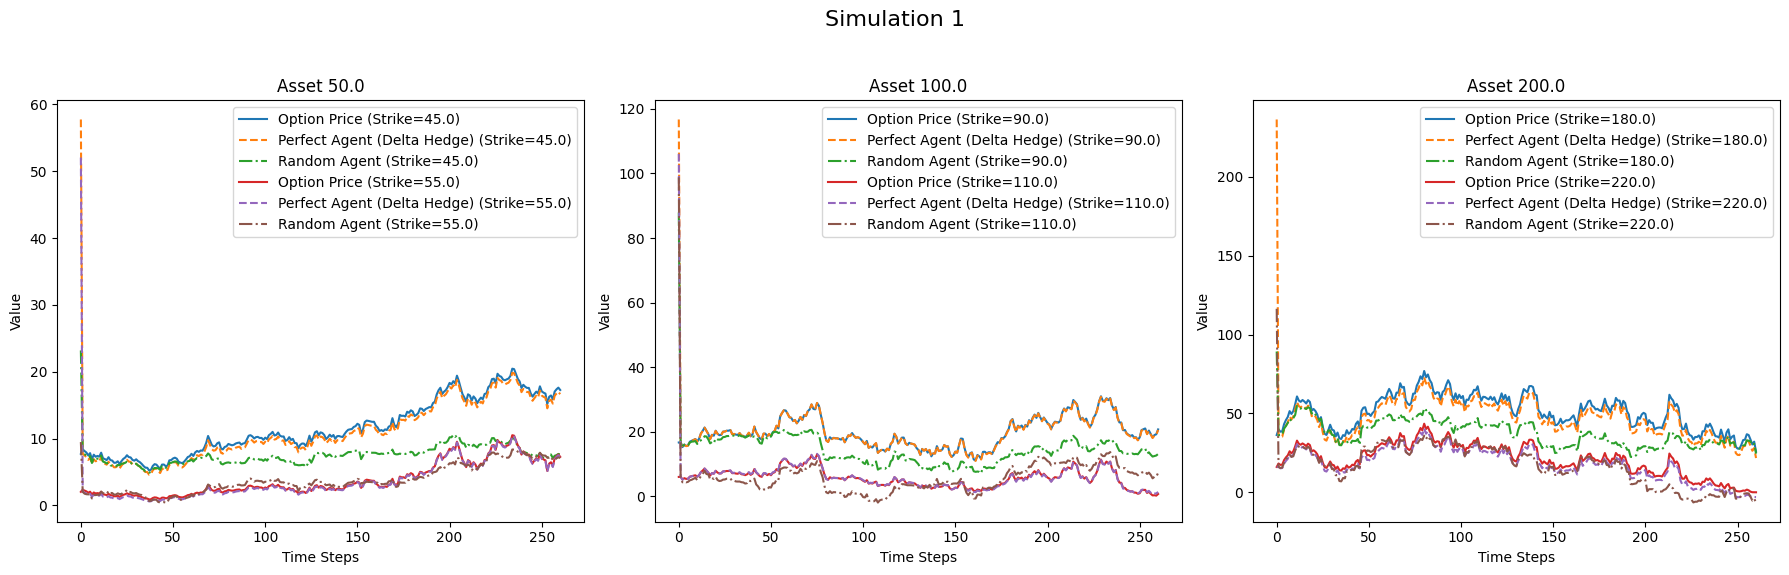

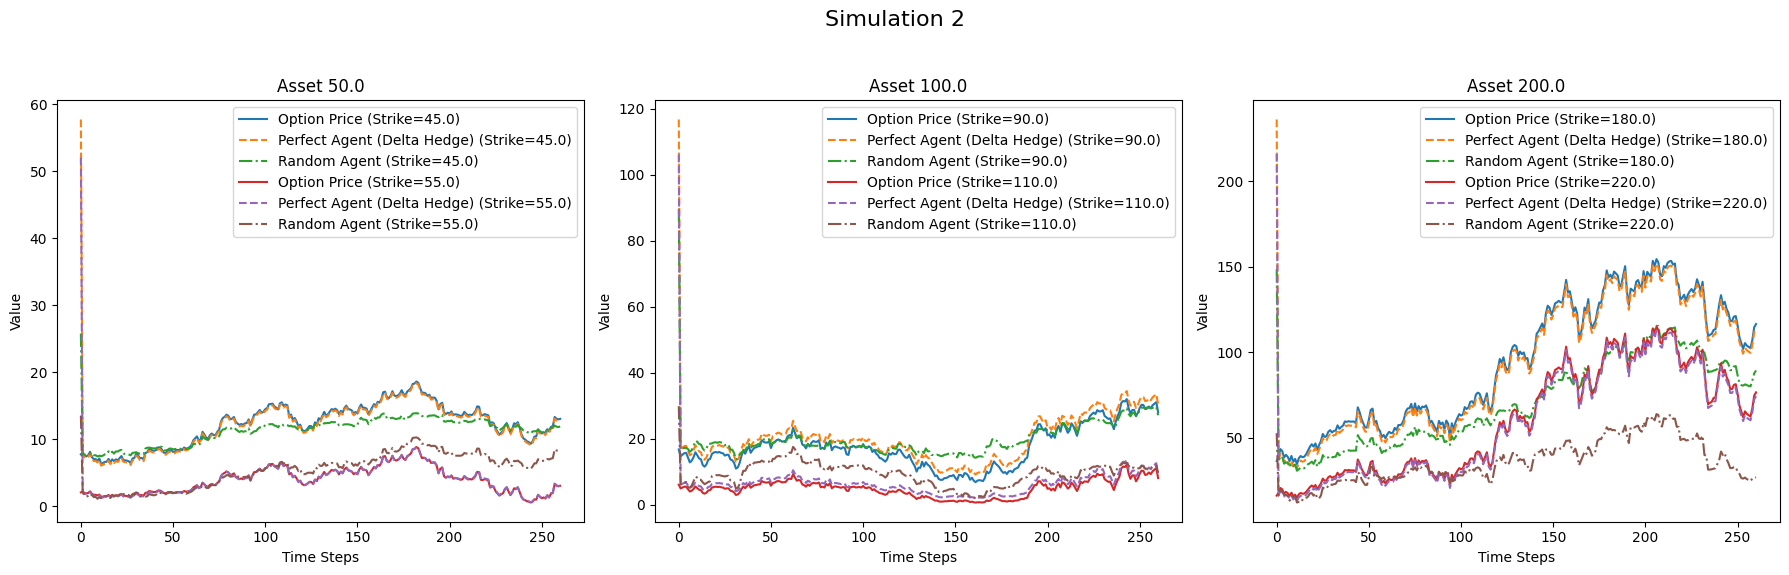

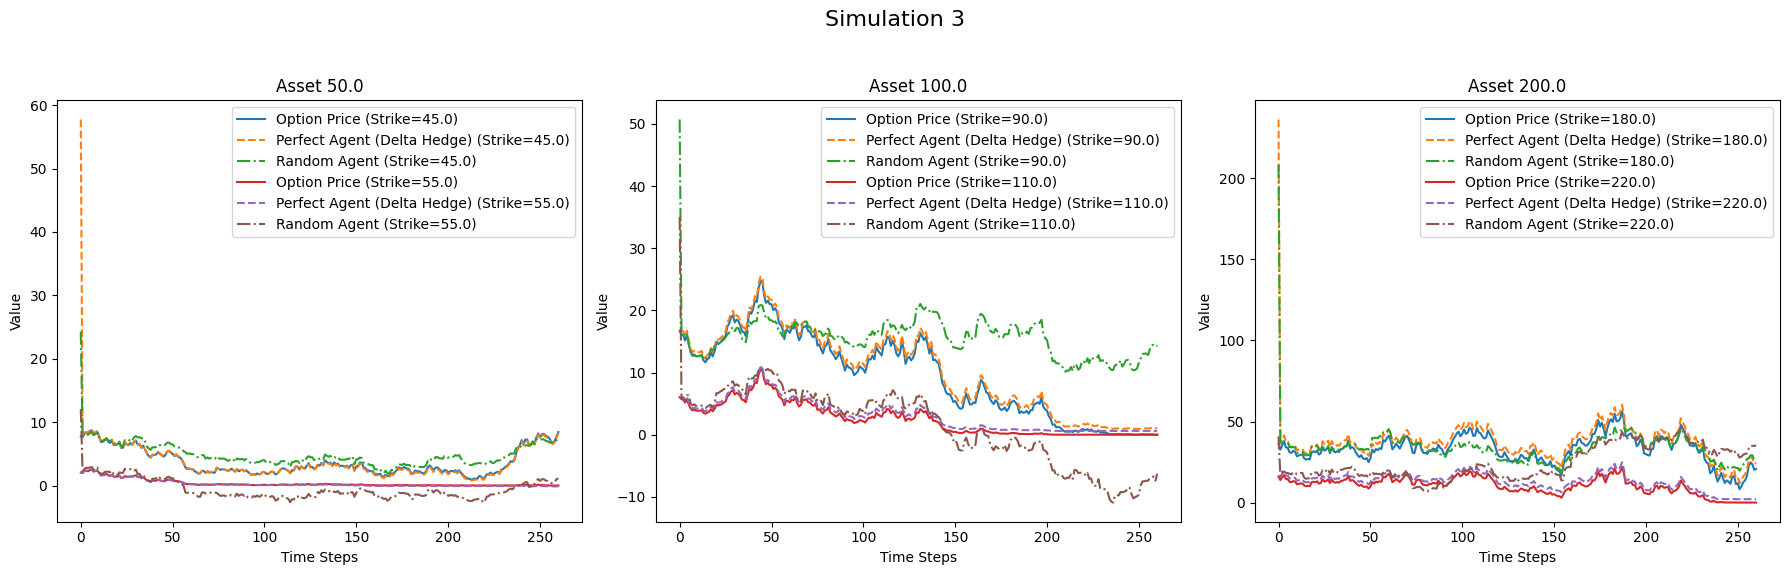

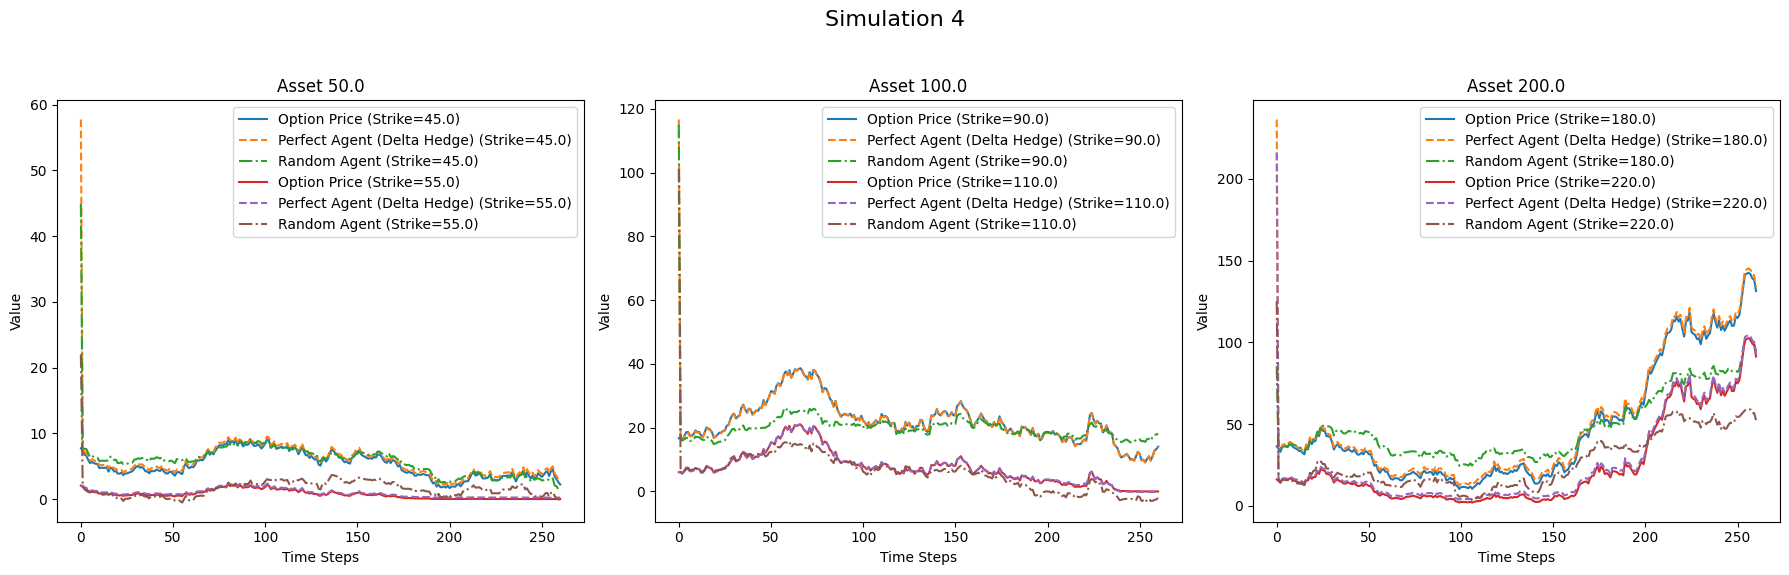

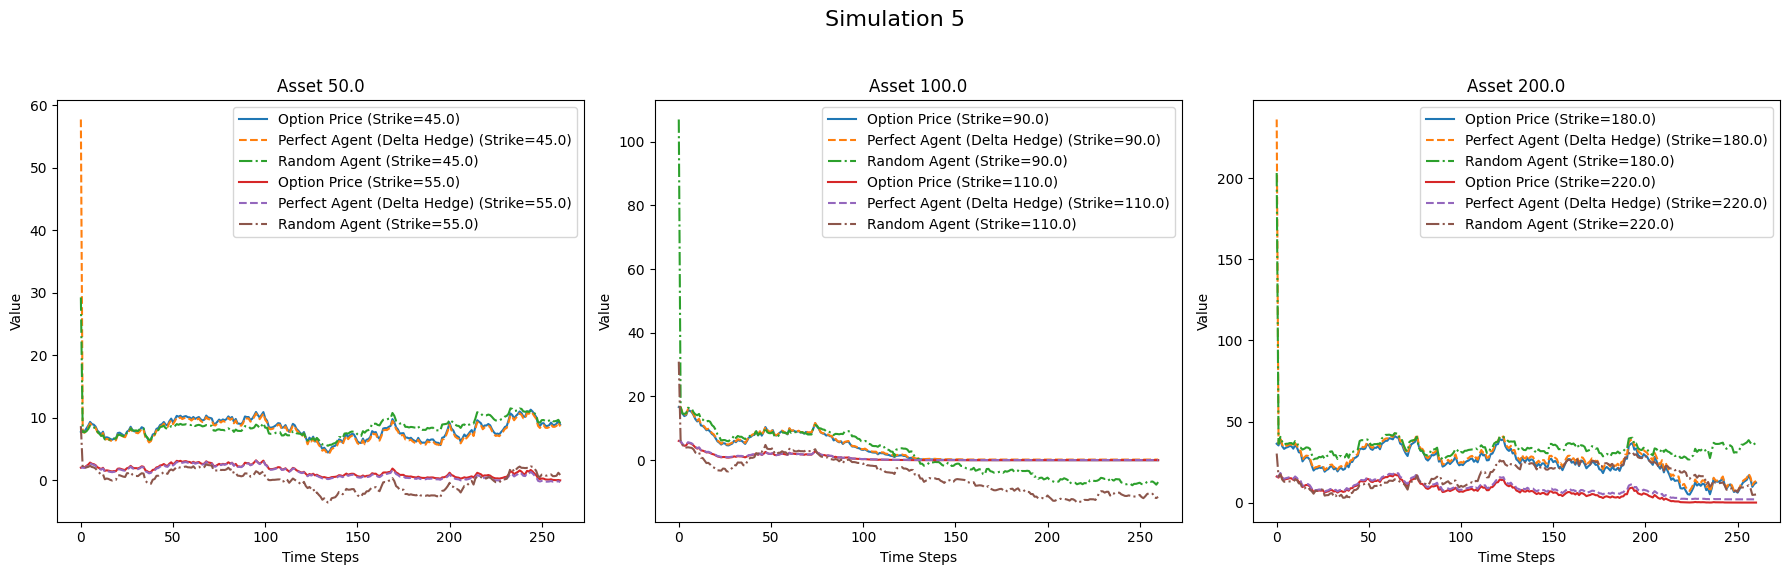

In [8]:
# --- Plotting ---
for idx in range(num_simulation_test):
    fig, axes = plt.subplots(1, len(K), figsize=(18, 6))
    fig.suptitle(f'Simulation {idx+1}', fontsize=16)

    for i in range(num_asset):
        for j in range(num_strike):
            axes[i].plot(option_prices_np[idx, i, j, :], linestyle='-', label=f'Option Price (Strike={K[i,j]})')
            axes[i].plot(portfolio_value_perfect[idx, i, j, :], linestyle='--', label=f'Perfect Agent (Delta Hedge) (Strike={K[i,j]})')
            axes[i].plot(portfolio_value_random[idx, i, j, :], linestyle='-.', label=f'Random Agent (Strike={K[i,j]})')

        axes[i].set_title(f'Asset {S0[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Value')
        axes[i].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
class BetaPolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, action_dim=1, history_len=10, dropout=0.0):
        super(BetaPolicyNetwork, self).__init__()
        self.history_len = history_len
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc_alpha = nn.Linear(hidden_size, action_dim)
        self.fc_beta = nn.Linear(hidden_size, action_dim)
        self.softplus = nn.Softplus() # Ensure alpha and beta are positive

    def forward(self, history_features):
        # history_features: (batch_size, history_len, feature_dim)
        batch_size = history_features.size(0)
        seq_len = history_features.size(1)

        # Pad history if shorter than history_len
        if seq_len < self.history_len:
            padding = torch.zeros(batch_size, self.history_len - seq_len, history_features.size(2), dtype=history_features.dtype, device=history_features.device)
            history_features = torch.cat([padding, history_features], dim=1)

        history_features = history_features.unsqueeze(0) if history_features.ndim == 2 else history_features # handle single step input

        lstm_out, _ = self.lstm(history_features) # out: tensor of shape (batch_size, seq_length, hidden_size)
        lstm_out = lstm_out[:, -1, :] # Take output from the last time step

        alpha = self.softplus(self.fc_alpha(lstm_out)) + 1.0 # Alpha > 1
        beta = self.softplus(self.fc_beta(lstm_out)) + 1.0 # Beta > 1
        return alpha, beta

def select_action(alpha, beta):
    m = Beta(alpha, beta)
    action = m.sample()
    return action, m.log_prob(action)

def train_policy_gradient(env, policy_net, optimizer, gamma, num_episodes, history_len=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net.to(device)

    for episode in range(num_episodes):
        log_probs_history = []
        rewards_history = []
        state_history = []
        action_history = []
        shares_held_history = []

        state = env.reset() # Initial state is feature vector
        state = torch.tensor(state, dtype=torch.float32).to(device) # Convert to tensor and move to device
        batch_size_env = state.shape[0] // (env.num_asset * env.num_strike)
        previous_shares_held = np.zeros((batch_size_env, env.num_asset, env.num_strike)) # Initial shares held is zero

        for t in range(env.num_step):
            # Prepare history features for LSTM input
            current_state_history = torch.stack(state_history[-history_len:] if len(state_history) > 0 else [torch.zeros_like(state[0]) for _ in range(history_len)], dim=1) if len(state_history) > 0 else torch.zeros(batch_size_env * env.num_asset * env.num_strike, history_len, state.shape[-1]).to(device) # zero pad at beginning

            # Get features for current step
            current_state_history = torch.cat([current_state_history[:, 1:, :], state.unsqueeze(1)], dim=1) if len(state_history) > 0 else torch.cat([torch.zeros(batch_size_env * env.num_asset * env.num_strike, history_len-1, state.shape[-1]).to(device), state.unsqueeze(1)], dim=1)

            alpha, beta = policy_net(current_state_history)
            action_shares_to_hold, log_prob = select_action(alpha, beta)

            # Convert action to numpy and reshape
            action_shares_to_hold_np = action_shares_to_hold.cpu().detach().numpy()
            action_shares_to_hold_reshaped = action_shares_to_hold_np.reshape(batch_size_env, env.num_asset, env.num_strike)

            # Calculate shares to trade
            shares_to_trade = action_shares_to_hold_reshaped - previous_shares_held

            next_state, reward, done, _ = env.step(shares_to_trade.reshape(-1,)) # Env expects action as flat array
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
            reward = torch.tensor(reward, dtype=torch.float32).to(device)

            # Store step information
            state_history.append(state)
            action_history.append(action_shares_to_hold)
            log_probs_history.append(log_prob)
            rewards_history.append(reward)
            shares_held_history.append(action_shares_to_hold_reshaped) # Store shares to hold for next step calculation
            previous_shares_held = action_shares_to_hold_reshaped # Update shares held for next step

            state = next_state
            if done:
                break

        # Calculate returns and advantages
        R = 0
        returns = []
        for r in reversed(rewards_history):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.stack(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8) # Normalize returns

        log_probs_history_tensor = torch.stack(log_probs_history)
        policy_loss = []
        for log_prob, R_t in zip(log_probs_history_tensor, returns):
            policy_loss.append(-log_prob * R_t)
        policy_loss = torch.stack(policy_loss).mean()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if episode % 10 == 0:
            print(f"Episode {episode}, Policy Loss: {policy_loss.item():.4f}")

    return policy_net

In [ ]:
# --- Training Parameters ---
S0 = np.array([50.0, 100.0, 200.0])
K = np.array([[45.0, 55.0], [90.0, 110.0], [180.0, 220.0]])
sigma = np.array([0.15, 0.2, 0.25])
r = 0.05

num_simulation_train = 256 # Increased simulations for training
num_step = 260
input_dim = 6 # Feature dimension
hidden_size = 64
num_layers = 2
learning_rate = 0.001
num_episodes = 200
gamma = 0.999
history_len = 10

# --- Initialize Environment and Policy Network ---
train_env = HedgingEnv(S0, K, sigma, r, num_simulation_train, num_step, seed=0)
policy = BetaPolicyNetwork(input_dim, hidden_size, num_layers, history_len=history_len)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)


# --- Training ---
trained_policy = train_policy_gradient(train_env, policy, optimizer, gamma, num_episodes, history_len=history_len)
print("Training finished!")

/tmp/ipykernel_1277466/1550918070.py:8: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1277466/1550918070.py:21: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1277466/1550918070.py:8: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1277466/1550918070.py:21: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


Episode 0, Policy Loss: -0.0001
Episode 10, Policy Loss: -0.0001
Episode 20, Policy Loss: 0.0001
Episode 30, Policy Loss: -0.0000
Episode 40, Policy Loss: 0.0003
Episode 50, Policy Loss: -0.0000
Episode 60, Policy Loss: -0.0001
Episode 70, Policy Loss: 0.0001
Episode 80, Policy Loss: -0.0000
Episode 90, Policy Loss: 0.0000
Episode 100, Policy Loss: -0.0001
Episode 110, Policy Loss: -0.0002
Episode 120, Policy Loss: 0.0002
Episode 130, Policy Loss: -0.0001
Episode 140, Policy Loss: 0.0006
Episode 150, Policy Loss: -0.0002
Episode 160, Policy Loss: 0.0000
Episode 170, Policy Loss: -0.0001
Episode 180, Policy Loss: 0.0001
Episode 190, Policy Loss: 0.0000
Training finished!


/tmp/ipykernel_1277466/1550918070.py:8: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1277466/1550918070.py:21: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


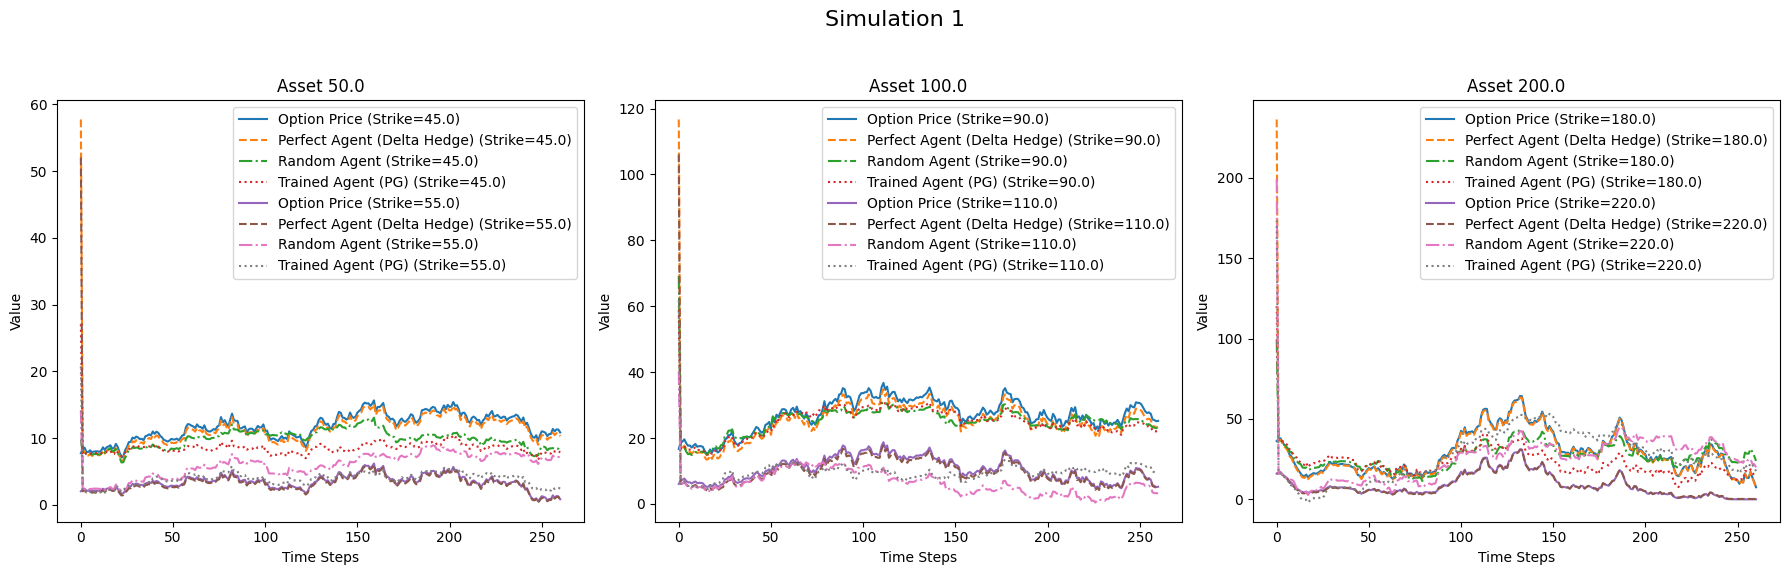

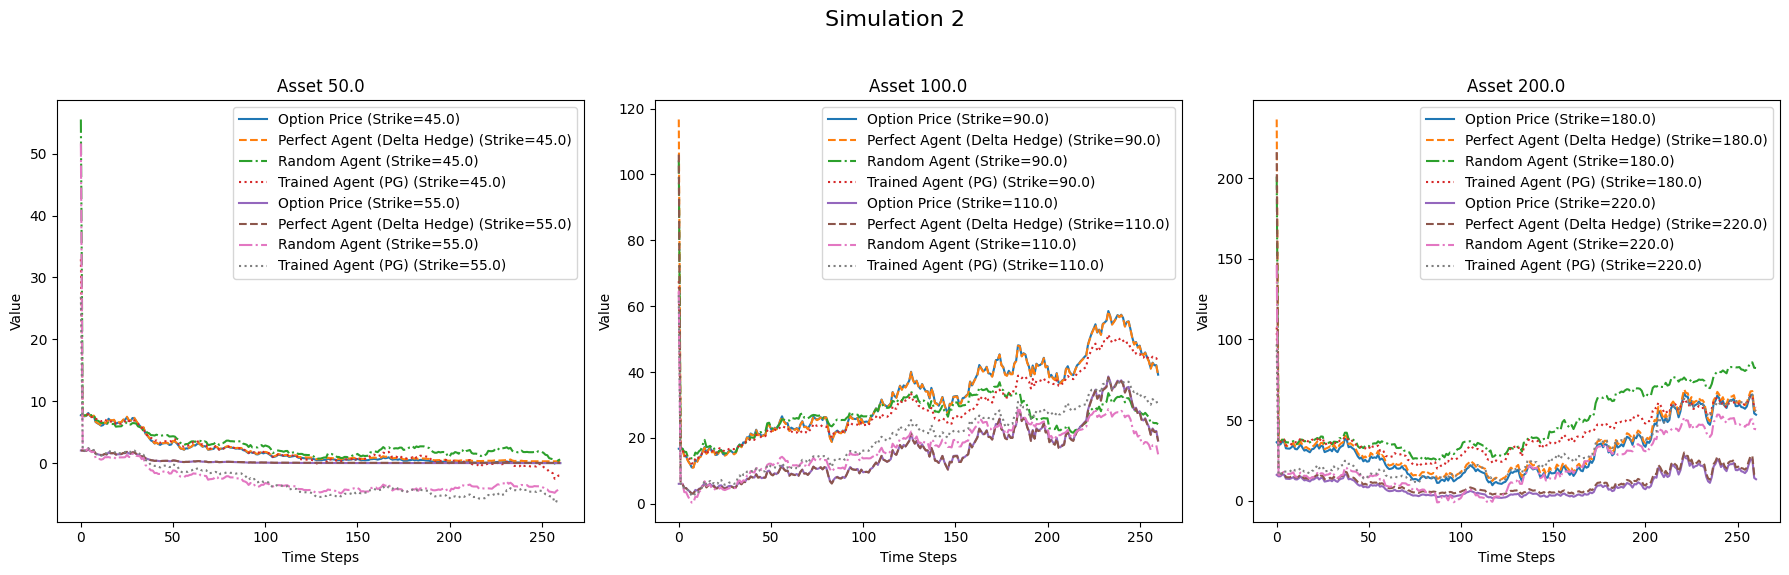

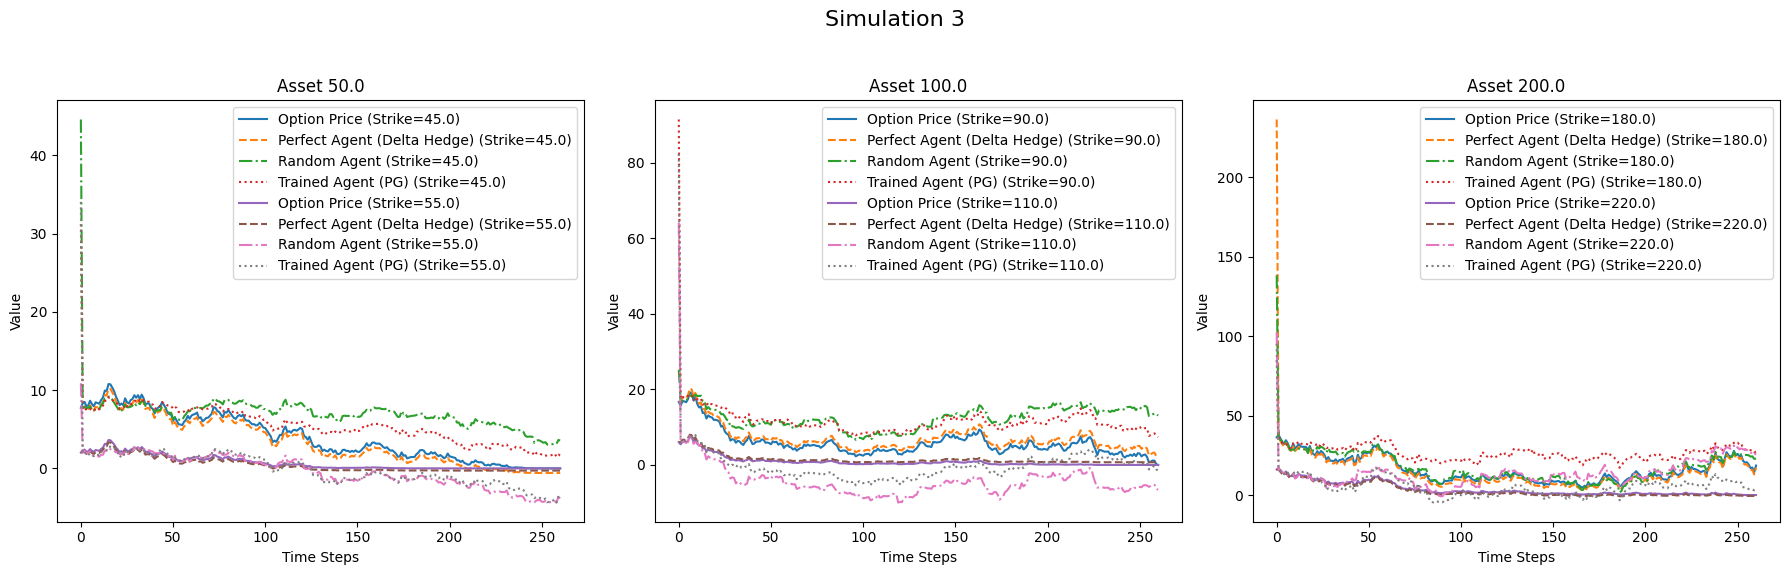

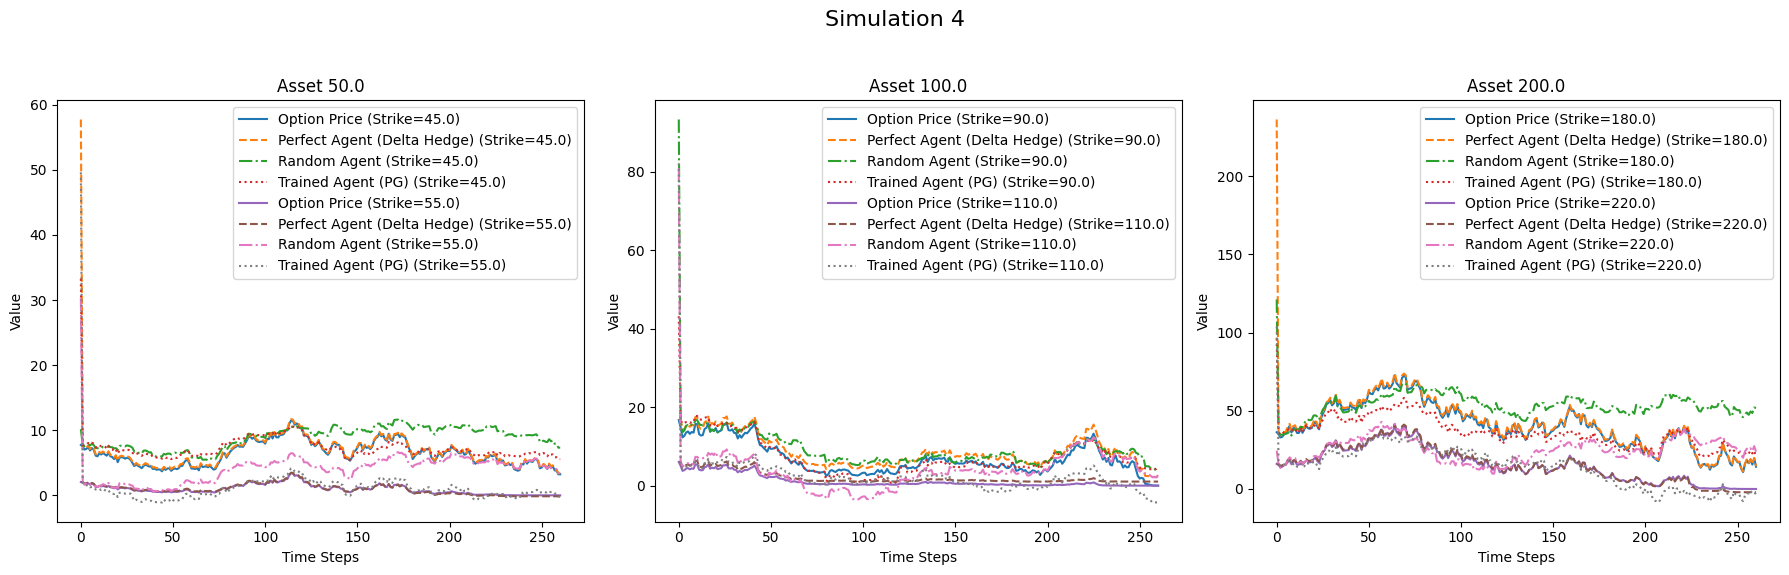

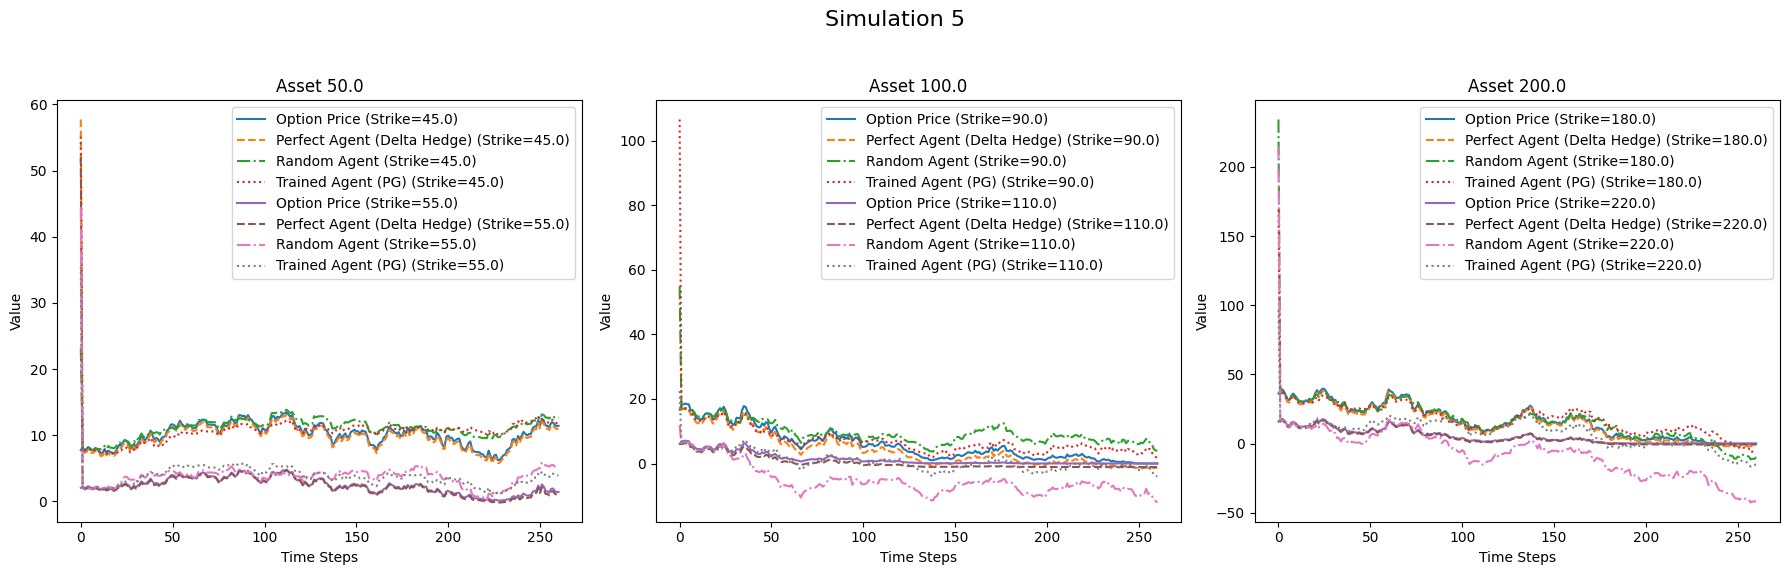

In [12]:
# --- Testing Parameters (same as before) ---
S0 = np.array([50.0, 100.0, 200.0])
K = np.array([[45.0, 55.0], [90.0, 110.0], [180.0, 220.0]])
sigma = np.array([0.15, 0.2, 0.25])
r = 0.05
num_simulation_test = 5 # Reduced simulations for plotting
num_step = 260
history_len = 10
input_dim = 6 # Feature dimension


# --- Initialize Test Environment and Policy Network ---
test_env = HedgingEnv(S0, K, sigma, r, num_simulation_test, num_step, seed=10) # Different seed for test
policy_net = trained_policy # Use the trained policy from the training phase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net.to(device).eval() # Set policy network to evaluation mode


# --- Initialize Portfolio Value Arrays ---
option_prices_np = test_env.option_prices
portfolio_value_perfect = np.zeros_like(option_prices_np)
portfolio_value_random = np.zeros_like(option_prices_np)
portfolio_value_trained = np.zeros_like(option_prices_np)


# --- Perfect Agent (Delta Hedging) Simulation (Reused from previous response) ---
test_env.reset()
shares_held_perfect = np.zeros((num_simulation_test, num_asset, num_strike))

for step in range(num_step):
    deltas = test_env.deltas[..., step+1]
    shares_to_trade_perfect = deltas - shares_held_perfect
    next_state, reward, done, _ = test_env.step(shares_to_trade_perfect)
    portfolio_value_perfect[..., step+1] = test_env.cash_account[..., step+1] + test_env.shares_held * test_env.stock_prices[..., step+1, None]
    shares_held_perfect = deltas

portfolio_value_perfect[...,0] = test_env.cash_account[...,0] + shares_held_perfect * test_env.stock_prices[...,0, None]


# --- Random Policy Agent Simulation (Reused from previous response) ---
test_env.reset()
shares_held_random = np.zeros((num_simulation_test, num_asset, num_strike))

for step in range(num_step):
    shares_to_hold_random = np.random.rand(num_simulation_test, num_asset, num_strike)
    shares_to_trade_random = shares_to_hold_random - shares_held_random
    next_state, reward, done, _ = test_env.step(shares_to_trade_random)
    portfolio_value_random[..., step+1] = test_env.cash_account[..., step+1] + test_env.shares_held * test_env.stock_prices[..., step+1, None]
    shares_held_random = shares_to_hold_random

portfolio_value_random[...,0] = test_env.cash_account[...,0] + shares_held_random * test_env.stock_prices[...,0, None]


# --- Trained Policy Agent Simulation ---
test_env.reset()
shares_held_trained = np.zeros((num_simulation_test, num_asset, num_strike))
state_history_test = []
state_test = test_env._get_state() # Get initial state for test
state_test_torch = torch.tensor(state_test, dtype=torch.float32).to(device)

for step in range(num_step):
    # Prepare history features for LSTM input
    current_state_history_test = torch.stack(state_history_test[-history_len:] if len(state_history_test) > 0 else [torch.zeros_like(state_test_torch[0]) for _ in range(history_len)], dim=1) if len(state_history_test) > 0 else torch.zeros(num_simulation_test * num_asset * num_strike, history_len, state_test_torch.shape[-1]).to(device) # zero pad at beginning

    # Get features for current step
    current_state_history_test = torch.cat([current_state_history_test[:, 1:, :], state_test_torch.unsqueeze(1)], dim=1) if len(state_history_test) > 0 else torch.cat([torch.zeros(num_simulation_test * num_asset * num_strike, history_len-1, state_test_torch.shape[-1]).to(device), state_test_torch.unsqueeze(1)], dim=1)

    with torch.no_grad(): # Disable gradient calculation during testing
        alpha_test, beta_test = policy_net(current_state_history_test)
        action_shares_to_hold_test, _ = select_action(alpha_test, beta_test)

    # Convert action to numpy and reshape
    action_shares_to_hold_test_np = action_shares_to_hold_test.cpu().detach().numpy()
    action_shares_to_hold_test_reshaped = action_shares_to_hold_test_np.reshape(num_simulation_test, num_asset, num_strike)

    shares_to_trade_trained = action_shares_to_hold_test_reshaped - shares_held_trained
    next_state_test, reward_test, done_test, _ = test_env.step(shares_to_trade_trained.reshape(-1,))
    portfolio_value_trained[..., step+1] = test_env.cash_account[..., step+1] + test_env.shares_held * test_env.stock_prices[..., step+1, None]
    shares_held_trained = action_shares_to_hold_test_reshaped

    state_history_test.append(state_test_torch)
    state_test = next_state_test
    state_test_torch = torch.tensor(state_test, dtype=torch.float32).to(device)


portfolio_value_trained[...,0] = test_env.cash_account[...,0] + shares_held_trained * test_env.stock_prices[...,0, None]


# --- Plotting (Reused and adapted from previous response) ---
for idx in range(num_simulation_test):
    fig, axes = plt.subplots(1, len(K), figsize=(18, 6))
    fig.suptitle(f'Simulation {idx+1}', fontsize=16)

    for i in range(num_asset):
        for j in range(num_strike):
            axes[i].plot(option_prices_np[idx, i, j, :], linestyle='-', label=f'Option Price (Strike={K[i,j]})')
            axes[i].plot(portfolio_value_perfect[idx, i, j, :], linestyle='--', label=f'Perfect Agent (Delta Hedge) (Strike={K[i,j]})')
            axes[i].plot(portfolio_value_random[idx, i, j, :], linestyle='-.', label=f'Random Agent (Strike={K[i,j]})')
            axes[i].plot(portfolio_value_trained[idx, i, j, :], linestyle=':', label=f'Trained Agent (PG) (Strike={K[i,j]})') # Added trained agent plot

        axes[i].set_title(f'Asset {S0[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Value')
        axes[i].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()